In [1]:
%reset
%load_ext autoreload
%autoreload 2

import sys

sys.path.append("../")
import torch
import numpy as np
import defmod as dm
import multimodule_usefulfunctions as mm 
import matplotlib.pyplot as plt
import defmod.hamiltonian_multishape as hamiltonian
import model_graddesc as model

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [2]:
nb_pts1 = 10
nb_pts2 = 7
dim = 2

o1 = torch.tensor([0,0]).float()
o2 = torch.tensor([10,0]).float()
origin = [o1,o2]
r1 = 2
r2 = 1
radius = [r1, r2]
nb_pts = [nb_pts1, nb_pts2]
source = mm.multipleCircles(origin, radius, nb_pts)

origin_target = [[0,5], [10,-5]]
target = mm.multipleCircles(origin_target, radius, nb_pts)

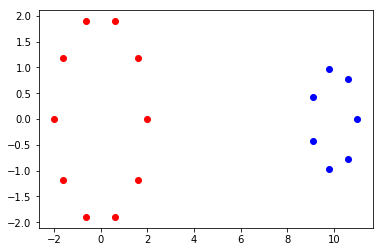

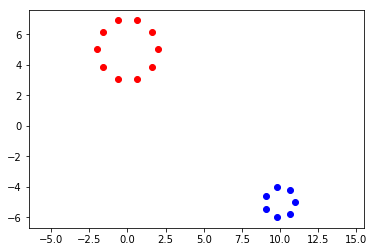

In [3]:
plt.figure()
plt.scatter(source[0][:, 0].detach().numpy(), source[0][:, 1].detach().numpy(), c='red')
plt.scatter(source[1][:, 0].detach().numpy(), source[1][:, 1].detach().numpy(), c='blue')

plt.figure()
plt.scatter(target[0][:, 0].detach().numpy(), target[0][:, 1].detach().numpy(), c='red')
plt.scatter(target[1][:, 0].detach().numpy(), target[1][:, 1].detach().numpy(), c='blue')

plt.axis('equal')
plt.show()

In [4]:
# Defining the deformation modules
sigma1 = 3
manifold1 = dm.manifold.Landmarks(dim, nb_pts1, gd=source[0].view(-1))
trans1 = dm.deformationmodules.Translations(manifold1, sigma1)

sigma2 = 3
manifold2 = dm.manifold.Landmarks(dim, nb_pts2, gd=source[1].view(-1))
trans2 = dm.deformationmodules.Translations(manifold2, sigma2)

module_list = [trans1, trans2]
sigma_bg = 0.1
modules = dm.multishape.MultiShapeModule(module_list, sigma_bg)

In [5]:
constr_Id = dm.constraints.Identity()
H = hamiltonian.Hamiltonian_multi(modules, constr_Id)

In [6]:
gd0_list = [*source, source]
mom0_list = [*[torch.zeros(gd.shape) for gd in modules.manifold.gd[:-1]], [torch.zeros(gd.shape) for gd in modules.manifold.gd[-1]]]

In [7]:
H.module.manifold.fill_gd([gd0_list[0].view(-1), gd0_list[1].view(-1), [gd0_list[2][0].view(-1), gd0_list[2][1].view(-1)]])
H.module.manifold.fill_cotan([mom0_list[0].view(-1), mom0_list[1].view(-1), [mom0_list[2][0].view(-1), mom0_list[2][1].view(-1)]])
H.geodesic_controls()

In [8]:
# set parameters
reg_param = 10**-2 # regularisation parameter

gd0_tensor = torch.cat([gd0_list[0], gd0_list[1], gd0_list[2][0], gd0_list[2][1]],0).requires_grad_().view(-1)
mom0_tensor = torch.cat([mom0_list[0], mom0_list[1], mom0_list[2][0], mom0_list[2][1]],0).requires_grad_().view(-1)
    
gd0_tensor.retain_grad()
mom0_tensor.retain_grad()
    
EnergyFunctional = model.EnergyFunctional(modules, H, constr_Id, target, dim, reg_param)

# do registration
X = [gd0_tensor, mom0_tensor]
X = model.gradientdescent(EnergyFunctional, X)

 iter : 0  ,total energy: 56.87947463989258
 iter : 1  ,total energy: 55.682823181152344
 iter : 2  ,total energy: 54.49032211303711
 iter : 3  ,total energy: 53.30195617675781
 iter : 4  ,total energy: 52.11771774291992
 iter : 5  ,total energy: 50.93759536743164
 iter : 6  ,total energy: 49.761573791503906
 iter : 7  ,total energy: 48.58963394165039
 iter : 8  ,total energy: 47.421775817871094
 iter : 9  ,total energy: 46.25798416137695
 iter : 10  ,total energy: 45.098243713378906
 iter : 11  ,total energy: 43.942543029785156
 iter : 12  ,total energy: 42.790870666503906
 iter : 13  ,total energy: 41.64322280883789
 iter : 14  ,total energy: 40.499568939208984
 iter : 15  ,total energy: 39.35991287231445
 iter : 16  ,total energy: 38.2242431640625
 iter : 17  ,total energy: 37.09253692626953
 iter : 18  ,total energy: 35.96479034423828
 iter : 19  ,total energy: 34.84099197387695
 iter : 20  ,total energy: 33.72112274169922
 iter : 21  ,total energy: 32.60517883300781
 iter : 22  ,t

In [9]:
EnergyFunctional.modules.compute_geodesic_variables(constr_Id)
constr_Id(EnergyFunctional.modules)

tensor([[-1.4901e-08, -1.9073e-06],
        [-1.4901e-08, -1.4305e-06],
        [-7.4506e-09,  0.0000e+00],
        [-2.9802e-08,  0.0000e+00],
        [ 5.9605e-08, -9.5367e-07],
        [-1.0431e-07,  4.7684e-07],
        [ 2.5332e-07,  3.3379e-06],
        [ 1.4901e-08,  1.4305e-06],
        [ 2.9802e-08,  9.5367e-07],
        [-1.4901e-08, -4.7684e-07],
        [ 2.9802e-08, -1.9073e-06],
        [-1.1176e-08, -3.8147e-06],
        [-2.9802e-08, -1.9073e-06],
        [-7.4506e-09, -1.9073e-06],
        [ 0.0000e+00,  9.5367e-07],
        [ 0.0000e+00, -2.8610e-06],
        [ 3.7253e-09, -9.5367e-07]], grad_fn=<CatBackward>)

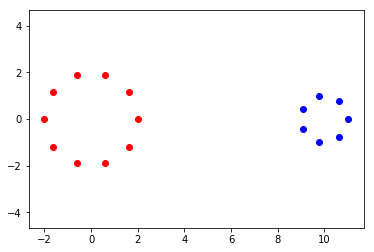

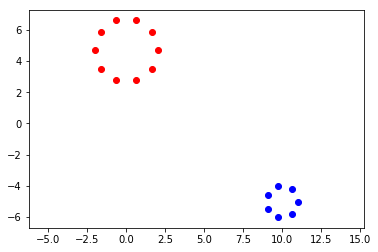

In [12]:
plt.figure()
plt.scatter(gd0_list[0].view(-1,2)[:, 0].detach().numpy(), gd0_list[0].view(-1,2)[:, 1].detach().numpy(), c='red')
plt.scatter(gd0_list[1].view(-1,2)[:, 0].detach().numpy(), gd0_list[1].view(-1,2)[:, 1].detach().numpy(), c='blue')
plt.axis('equal')


gd_moved = EnergyFunctional.h.module.manifold.gd

plt.figure()
plt.scatter(gd_moved[0].view(-1,2)[:, 0].detach().numpy(), gd_moved[0].view(-1,2)[:, 1].detach().numpy(), c='red')
plt.scatter(gd_moved[1].view(-1,2)[:, 0].detach().numpy(), gd_moved[1].view(-1,2)[:, 1].detach().numpy(), c='blue')

plt.axis('equal')
plt.show()

In [58]:
gd_moved


[tensor([ 2.0219,  4.6797,  1.6351,  5.8674,  0.6244,  6.6010, -0.6244,  6.6010,
         -1.6351,  5.8674, -2.0219,  4.6797, -1.6363,  3.4911, -0.6251,  2.7561,
          0.6251,  2.7561,  1.6363,  3.4911], grad_fn=<AddBackward0>),
 tensor([11.0078, -5.0226, 10.6284, -4.2348,  9.7757, -4.0403,  9.0920, -4.5854,
          9.0921, -5.4597,  9.7758, -6.0047, 10.6283, -5.8102],
        grad_fn=<AddBackward0>),
 [tensor([ 2.0219,  4.6797,  1.6351,  5.8674,  0.6244,  6.6010, -0.6244,  6.6010,
          -1.6351,  5.8674, -2.0219,  4.6797, -1.6363,  3.4911, -0.6251,  2.7561,
           0.6251,  2.7561,  1.6363,  3.4911], grad_fn=<AddBackward0>),
  tensor([11.0078, -5.0226, 10.6284, -4.2348,  9.7757, -4.0403,  9.0920, -4.5854,
           9.0921, -5.4597,  9.7758, -6.0047, 10.6283, -5.8102],
         grad_fn=<AddBackward0>)]]

In [59]:
man_final = EnergyFunctional.h.module.manifold


l, h = EnergyFunctional.h.module.compute_geodesic_variables(constr_Id)
constr_final = constr_Id(EnergyFunctional.h.module)
print(constr_final)
print(torch.dot(l.view(-1), constr_final.view(-1)))

tensor([[ 1.0431e-07,  9.5367e-07],
        [ 0.0000e+00, -1.4305e-06],
        [-8.1956e-08,  0.0000e+00],
        [ 2.2352e-08, -2.3842e-06],
        [ 2.9802e-08, -9.5367e-07],
        [ 8.9407e-08,  0.0000e+00],
        [-5.9605e-08, -4.7684e-07],
        [ 7.4506e-08,  0.0000e+00],
        [-2.2352e-08, -4.7684e-07],
        [ 2.5332e-07, -1.4305e-06],
        [-4.4703e-08,  0.0000e+00],
        [-1.4901e-08,  0.0000e+00],
        [-5.0291e-08,  9.5367e-07],
        [-5.2154e-08,  9.5367e-07],
        [ 0.0000e+00,  0.0000e+00],
        [-1.1176e-08,  9.5367e-07],
        [-5.2154e-08,  1.9073e-06]], grad_fn=<CatBackward>)
tensor(-2.3131e-05, grad_fn=<DotBackward>)
